# Preprocess-change npy to image

11025


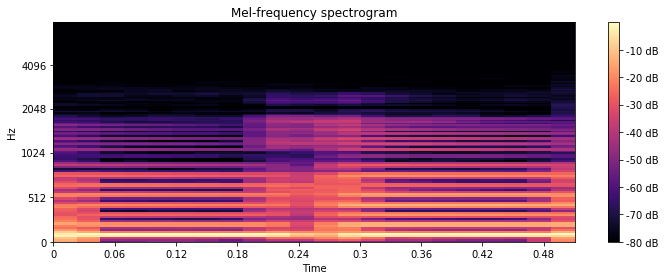

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display 

y = np.load('DSP_HW/test.npy',allow_pickle=True)
print(len(y[0]))
S= librosa.feature.melspectrogram(y=y[0])
plt.figure(figsize=(10, 4))
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', 
                         fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

# 1,2,3 Classification
1. how to load the dataset
2. how to use pre-processing
3. how to train the model
4. how to save and load your well-trained model
5. how to test your performance
6. how to obtain predictions from a few images
7. how to visual your results

In [1]:
# import some libraries you maybe use
import torchvision # an useful library to help I/O (highly recommend). To install this, just do "pip install torchvision"
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# Data loading and preprocessing
In order to train the model with training data, the first step is to read the data from your folder, database, etc. The below is just an example.

In [2]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, ToTensor, Grayscale, Resize, Normalize
from torch.utils.data import DataLoader
import os

# Define path to your dataset
dataset = "123" # the root folder
trainpath = os.path.join(dataset,"train") # train set
valpath = os.path.join(dataset,"val") # validation set


# Define some operations to preprocess your inputs.
mytransforms = Compose([Grayscale(num_output_channels=1),Resize((32,32)),ToTensor()])
# The above line will work in this flow:
# (PIL_RGB_INPUT) => (PIL_GrayScale_INPUT) => (32x32_PIL_GrayScale_INPUT) => (32x32_Tensor_GrayScale_INPUT)

# Create imagefolder object.
# The ImageFolder(...) is a powerful class to load the data from the folders.
# The data should be arranged in this manner:
# root/dog/xxx.png
# root/dog/xxy.png
# root/dog/xxz.png
# ...
# root/cat/123.png
# root/cat/nsdf3.png
# root/cat/asd932_.png
# =============================================
# To learn more, please visit the website:
# 1. Official API LINK: https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder
# 2. Good Explaination LINK: https://discuss.pytorch.org/t/questions-about-imagefolder/774/6
traindata = ImageFolder(root=trainpath, transform=mytransforms)
valdata = ImageFolder(root=valpath,transform=mytransforms)

# Create a loader
trainloader = DataLoader(traindata,batch_size=64,shuffle=True)
valloader = DataLoader(valdata,batch_size=64,shuffle=True)

In [3]:
print(traindata.classes) # show all classes
print(traindata.class_to_idx) # show the mapping from class to index.

['one', 'three', 'two']
{'two': 2, 'one': 0, 'three': 1}


In [4]:
idx_to_class = {val: key for key, val in traindata.class_to_idx.items()} # build an inverse mapping for later use
print(idx_to_class)

{0: 'one', 1: 'three', 2: 'two'}


# Build an example network
If you're unfamiliar with this part, please see the HW1 tutorial.

In [5]:
class Net(nn.Module):
    def __init__(self,num_classes):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, num_classes)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [6]:
net = Net(num_classes=len(traindata.classes)) # initialize your network
# Whether to use GPU or not?
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
else: 
    device = 'cpu'
print("use",device,"now!")
net.to(device)
optimizer = optim.SGD(net.parameters(), lr=0.05) # setup your optimizer
criterion = nn.CrossEntropyLoss() # setup your criterion

use cuda now!


# Train the model with the data

In [7]:
net.train()
num_epoch = 10
for epoch in range(num_epoch):
    for batch_idx, (data, target) in enumerate(trainloader):
        #print(data.shape,target)
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 5==0:
            print('epoch %d, iter %d loss: %.3f' %(epoch+1, batch_idx+1, loss.item()))

epoch 1, iter 1 loss: 1.104
epoch 1, iter 6 loss: 1.099
epoch 1, iter 11 loss: 1.095
epoch 1, iter 16 loss: 1.094
epoch 1, iter 21 loss: 1.091
epoch 2, iter 1 loss: 1.093
epoch 2, iter 6 loss: 1.087
epoch 2, iter 11 loss: 1.083
epoch 2, iter 16 loss: 1.080
epoch 2, iter 21 loss: 1.076
epoch 3, iter 1 loss: 1.068
epoch 3, iter 6 loss: 1.060
epoch 3, iter 11 loss: 1.043
epoch 3, iter 16 loss: 1.024
epoch 3, iter 21 loss: 0.991
epoch 4, iter 1 loss: 0.937
epoch 4, iter 6 loss: 0.824
epoch 4, iter 11 loss: 0.678
epoch 4, iter 16 loss: 0.531
epoch 4, iter 21 loss: 0.614
epoch 5, iter 1 loss: 0.398
epoch 5, iter 6 loss: 0.315
epoch 5, iter 11 loss: 0.304
epoch 5, iter 16 loss: 0.173
epoch 5, iter 21 loss: 0.152
epoch 6, iter 1 loss: 0.222
epoch 6, iter 6 loss: 0.166
epoch 6, iter 11 loss: 0.187
epoch 6, iter 16 loss: 0.167
epoch 6, iter 21 loss: 0.202
epoch 7, iter 1 loss: 0.142
epoch 7, iter 6 loss: 0.401
epoch 7, iter 11 loss: 0.121
epoch 7, iter 16 loss: 0.172
epoch 7, iter 21 loss: 0.157

# Save model

In [8]:
def save_model(model,filename):
    state = model.state_dict()
    for key in state: state[key] = state[key].clone().cpu()
    torch.save(state, filename)
save_model(net,"weight.pth")

# Load model

In [9]:
def load_model(model,filename):
    model.load_state_dict(torch.load(filename))
    return model
net = Net(num_classes=len(traindata.classes)) # initialize your network
net = load_model(net,"weight.pth")
# Whether to use GPU or not?
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
else: 
    device = 'cpu'
print("use",device,"now!")
net.to(device)

use cuda now!


Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)

# Evaluate on validation data

In [10]:
net.eval()
correct = 0
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(valloader):
        data = data.to(device)
        target = target.to(device)
        output = net(data)
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum()
    acc = correct.item() / len(valloader.dataset)
print("Validation Classification Accuracy: %f"%(acc))

Validation Classification Accuracy: 0.966667


# How to obtain predictions from a few images
Note. There are many ways to do the same things such as customized dataset*. The below is just a simple example how I make an inference on a few images.

* https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

In [11]:
# fetch filepaths of the testing images
testpath = os.path.join(dataset,"test") # test set
testlist = [os.path.join(testpath,imgpath) for imgpath in os.listdir(testpath)]

In [12]:
# ImagePath => PIL_Image => Tensor
from PIL import Image
testdata = []
for imgpath in testlist:
    # In torchvision, we assume input images are all PIL types
    img = Image.open(imgpath).convert("RGB") # By default, torchvision read images in RGB-fashion
    transimg = mytransforms(img)
    testdata.append(transimg)
testdata = torch.stack(testdata)# list of tensors to tensor
testdata = torch.utils.data.TensorDataset(testdata)
# =========================================================================
# Don't shuffle the image list and set the batch_size = 1
# It's just a trick. You can still figure out another way to achieve the same thing.
testloader = torch.utils.data.DataLoader(testdata,batch_size=1,shuffle=False)

In [13]:
# Testing
net.eval()
result = {}
with torch.no_grad():
    for idx, (data,) in enumerate(testloader):
        data = data.to(device)
        target = target.to(device)
        output = net(data)
        pred_idx = output.data.max(1, keepdim=True)[1]
        pred_class = idx_to_class[pred_idx.cpu().numpy()[0][0]]
        print("predict",testlist[idx],"=>",pred_class)
        result[testlist[idx]] = pred_class

predict 123\test\1118.jpg => three
predict 123\test\1282.jpg => three
predict 123\test\1384.jpg => one
predict 123\test\1395.jpg => one
predict 123\test\306.jpg => two
predict 123\test\357.jpg => two


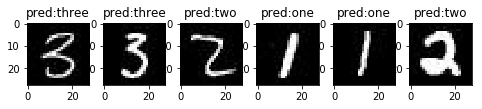

In [15]:
# Visualize your results
import matplotlib.pyplot as plt
size = 8
fig = plt.figure(figsize=(size, size))
columns = len(result)
rows = np.ceil(len(result))
for x, filepath in enumerate(result):
    img = plt.imread(filepath)
    ax = fig.add_subplot(rows, columns, x+1)
    ax.set_title("pred:%s"%(result[filepath]))
    plt.imshow(img,cmap='gray')
plt.show()